# Fraud Detection System

### Data Mining Pipeline
1. Problem Statement
2. Data Collection
3. Data Analysis and Visualization
4. Data Processing
5. Model Selection and Training
6. Model Evaulation 

In [1]:
!pip install kaggle

In [2]:
# data retrieval
import os
import io
import zipfile
import shutil

# data analysis
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# models
# -

# other
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Data Collection (Retrieval Using Kaggle Key)
- You must have a Kaggle account and API key to retrieve their dataset. To retrieve the key, follow: https://www.kaggle.com/docs/api
- Then, download the paysim1.zip from https://www.kaggle.com/datasets/ealaxi/paysim1 and add within the same directory as this notebook file.

In [3]:
# Set your Kaggle API key credentials (replace with your own values)
os.environ['KAGGLE_USERNAME'] = 'your_username'
os.environ['KAGGLE_KEY'] = 'your_api_key'

In [4]:
if not os.path.exists("paysim1.zip"):
    # Use Kaggle CLI to download the "paysim1" dataset
    !kaggle datasets download -d ealaxi/paysim1
    
if os.path.exists("paysim1.zip"):
    with zipfile.ZipFile("paysim1.zip", "r") as zip_ref:
        zip_ref.extractall("paysim1")
        
    # Specify the path to the CSV file
    csv_file_path = "paysim1/PS_20174392719_1491204439457_log.csv"
    
    # Read the CSV file content into memory
    with open(csv_file_path, "rb") as f:
        csv_content = f.read()
    shutil.rmtree("paysim1")
else:
    print("The paysim1.zip file is missing. Dataset not downloaded.")


### Data Analysis
In the next two sections, we will perform a data analysis by description and by data visualization.

After reading in the dataset, we see eleven different features:
- **step**: time length of transaction (1 step = 1 hour)
- **type**: type of transaction (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER)
- **amount**: amount of money (dollars) involved
- **nameOrig**: ID of sender
- **oldbalanceOrg**: initial balance of sender
- **newbalanceOrig**: final balance of sender
- **nameDest**: ID of recipient
- **oldBalanceDest**: initial balance of recipient
- **newBalanceDest**: final balance of recipient
- **isFraud**: a flag for fradulent (1) and non-fraudulent (0) transactions
- **isFlaggedFraud**: a flag that checks if transaction has been flagged as fraud (1) or not (0)

In [5]:
data = pd.read_csv(io.BytesIO(csv_content))
print(data.columns.values)

['step' 'type' 'amount' 'nameOrig' 'oldbalanceOrg' 'newbalanceOrig'
 'nameDest' 'oldbalanceDest' 'newbalanceDest' 'isFraud' 'isFlaggedFraud']


From the names of the attributes shown, we find inconsistency in the naming convention. We update the name of newBalanceOrg to newbalanceOrig to match with the other attribute names.

In [6]:
data.rename(columns={'newbalanceOrig':'newbalanceOrg'},inplace=True)

In the first step of our analysis, we check to see if our data set has any null values. 
We find that there are **no NULL values** in all eleven features.

In [7]:
print('Data does not have any NULL value.')
data.isnull().any()

Data does not have any NULL value.


step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrg     False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

**Feature Data Types**

Next, we check the data types for the eleven features. Here, we found:
* Three features are object/string type.
* Three features are integers.
* Five features are floats.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrg   float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Out of the three object types, we drop **nameOrig** and **nameDest**, because __. Which leaves us with only nine features to wrangle with.

In [9]:
data.drop(labels=['nameOrig','nameDest'],axis=1,inplace=True)
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrg,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


Finally, we note the minimum and maximum values of the amount, oldbalanceOrig, newbalanceOrig, oldbalanceDest, and newBalanceDest.
*Something interesting to note is that there are transaction amounts that is at $0, after applying the minimum. This indicates that no money was sent or received in certain transactions. These transactions may be classified as noise that can be removed later.*


In [10]:
print('Minimum value of Amount, Old/New Balance of Origin/Destination:')
data[[ 'amount','oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']].min()

Minimum value of Amount, Old/New Balance of Origin/Destination:


amount            0.0
oldbalanceOrg     0.0
newbalanceOrg     0.0
oldbalanceDest    0.0
newbalanceDest    0.0
dtype: float64

In [11]:
print('Maximum value of Amount, Old/New Balance of Origin/Destination:')
data[[ 'amount','oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']].max()

Maximum value of Amount, Old/New Balance of Origin/Destination:


amount            9.244552e+07
oldbalanceOrg     5.958504e+07
newbalanceOrg     4.958504e+07
oldbalanceDest    3.560159e+08
newbalanceDest    3.561793e+08
dtype: float64

### Data Visualization

Text(0, 0.5, 'Amount')

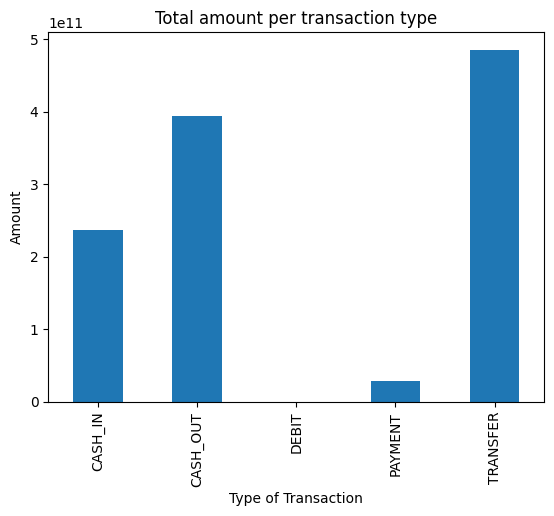

In [12]:
var = data.groupby('type').amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
var.plot(kind='bar')
ax1.set_title("Total amount per transaction type")
ax1.set_xlabel('Type of Transaction')
ax1.set_ylabel('Amount')

In [13]:
data.loc[data.isFraud == 1].type.unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)

In [14]:
sns.heatmap(data.corr(),cmap='RdBu');

ValueError: could not convert string to float: 'PAYMENT'

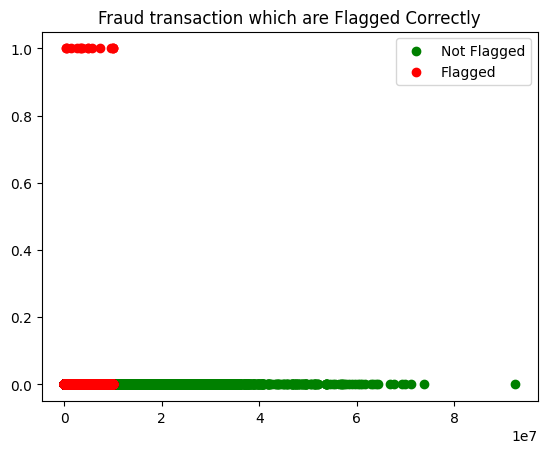

In [15]:
fraud = data.loc[data.isFraud == 1]
nonfraud = data.loc[data.isFraud == 0]

fig = plt.figure()
axes = fig.add_subplot(1,1,1)
axes.set_title("Fraud transaction which are Flagged Correctly")
axes.scatter(nonfraud['amount'],nonfraud['isFlaggedFraud'],c='g')
axes.scatter(fraud['amount'],fraud['isFlaggedFraud'],c='r')
plt.legend(loc='upper right',labels=['Not Flagged','Flagged'])
plt.show()

### Data Pre-processing